# Black-Scholes European Option Pricing Script

In [35]:
# File Contains: Python code containing closed-form solutions for the valuation of European Options,
# for backward compatability with Python 2.7
from __future__ import division

# import necessary libaries
import math
import numpy as np
from scipy.stats import norm
from scipy.stats import mvn

# Plotting
import matplotlib.pylab as pl
import numpy as np

# Option Pricing Theory: Black-Scholes model
Black Scholes genre option models widely used to value European options. The original “Black Scholes” model was published in 1973 for non-dividend paying stocks. Since that time, a wide variety of extensions to the original Black Scholes model have been created. Modifications of the formula are used to price other financial instruments like dividend paying stocks, commodity futures, and FX forwards. Mathematically, these formulas are nearly identical. The primary difference between these models is whether the asset has a carrying cost (if the asset has a cost or benefit associated with holding it) and how the asset gets present valued. To illustrate this relationship, a “generalized” form of the Black Scholes equation is shown below.

The Black Scholes model is based on number of assumptions about how financial markets operate. Black Scholes style models assume:

1.	**Arbitrage Free Markets**. Black Scholes formulas assume that traders try to maximize their personal profits and don’t allow arbitrage opportunities (riskless opportunities to make a profit) to persist. 
2.	**Frictionless, Continuous Markets**. This assumption of frictionless markets assumes that it is possible to buy and sell any amount of the underlying at any time without transaction costs.
3.	**Risk Free Rates**. It is possible to borrow and lend money at a risk-free interest rate
4.	**Log-normally Distributed Price Movements**. Prices are log-normally distributed and described by Geometric Brownian Motion
5.	**Constant Volatility**. The Black Scholes genre options formulas assume that volatility is constant across the life of the option contract. 

In practice, these assumptions are not particularly limiting. The primary limitation imposed by these models is that it is possible to (reasonably) describe the dispersion of prices at some point in the future in a mathematical equation. 

An important concept of Black Scholes models is that the actual way that the underlying asset drifts over time isn't important to the valuation. Since European options can only be exercised when the contract expires, it is only the distribution of possible prices on that date that matters - the path that the underlying took to that point doesn't affect the value of the option. This is why the primary limitation of the model is being able to describe the dispersion of prices at some point in the future, not that the dispersion process is simplistic.

The generalized Black-Scholes formula can found below (see *Figure 1 – Generalized Black Scholes Formula*). While these formulas may look complicated at first glance, most of the terms can be found as part of an options contract or are prices readily available in the market.  The only term that is difficult to calculate is the implied volatility (σ). Implied volatility is typically calculated using prices of other options that have recently been traded.

>*Call Price*
>\begin{equation}
C = Fe^{(b-r)T} N(D_1) - Xe^{-rT} N(D_2)
\end{equation}

>*Put Price*
>\begin{equation}
P = Xe^{-rT} N(-D_2) - Fe^{(b-r)T} N(-D_1)
\end{equation}

>*with the following intermediate calculations*

>\begin{equation}
D_1 = \frac{ln\frac{F}{X} + (b+\frac{V^2}{2})T}{V*\sqrt{T}}
\end{equation}

>\begin{equation}
D_2 = D_1 - V\sqrt{T}
\end{equation}

>*and the following inputs*

>|    Symbol    |    Meaning    |
>|--------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
>|    F or S   |    **Underlying Price**. The price of the underlying asset on the valuation date. S is used commonly used to represent a spot price, F a forward price     |
>|    X    |    **Strike Price**.   The strike, or exercise, price of the option.    |
>|    T    |    **Time to expiration**. The time to expiration in years. This can be calculated   by comparing the time between the expiration date and the valuation date.   T   = (t_1 - t_0)/365    |
>|    t_0    |    **Valuation Date**.   The date on which the option is being valued. For example, it might be   today’s date if the option we being valued today.    |
>|    t_1    |    **Expiration Date**.   The date on which the option must be exercised.    |
>|    V    |    **Volatility**.   The volatility of the underlying security. This factor usually cannot be directly observed in the market. It is most often calculated by looking at the prices for recent option transactions and back-solving a Black Scholes style equation to find the volatility that would result in the observed price. This is commonly abbreviated with the greek letter sigma,σ, although V is used here for consistency with the code below.    |
>|    q    |    **Continuous Yield**.   Used in the Merton model, this is the continuous yield of the underlying   security. Option holders are typically not paid dividends or other payments   until they exercise the option. As a result, this factor decreases the value   of an option.    |
>|    r    |    **Risk Free Rate**. This is expected return on a risk-free investment. This   is commonly a approximated by the yield on a low-risk government bond or the   rate that large banks borrow between themselves (LIBOR). The rate depends on   tenor of the cash flow. For example, a 10-year risk-free bond is likely to   have a different rate than a 20-year risk-free bond.[DE1]     |
>|    rf    |    **Foreign   Risk Free Rate**. Used in the Garman Kohlhagen model, this is the risk   free rate of the foreign currency. Each currency will have a risk free rate.    |
>*Figure 1 - Generalized Black Scholes Formula*

## Model Implementation
These functions encapsulate a generic version of the pricing formulas. They are primarily intended to be called by the other functions within this libary. The following functions will have a fixed interface so that they can be called directly for academic applicaitons that use the cost-of-carry (b) notation:

    _GBS()                  A generalized European option model   
    _GBS_ImpliedVol()       A generalized European option implied vol calculator
    
The other functions in this libary are called by the four main functions and are not expected to be interface safe (the implementation and interface may change over time).

### Implementation for European Options

In [36]:
# The primary class for calculating Generalized Black Scholes option prices and deltas
# It is not intended to be part of this module's public interface

# Inputs: option_type = "p" or "c", fs = price of underlying, x = strike, t = time to expiration, r = risk free rate
#         b = cost of carry, v = implied volatility
# Outputs: value, delta, gamma, theta, vega, rho
def _gbs(option_type, fs, x, t, r, b, v):
    _debug("Debugging Information: _gbs()")
    
    # -----------
    # Create preliminary calculations
    t__sqrt = math.sqrt(t)
    d1 = (math.log(fs / x) + (b + (v * v) / 2) * t) / (v * t__sqrt)
    d2 = d1 - v * t__sqrt

    if option_type == "c":
        # it's a call
        _debug("     Call Option")
        value = fs * math.exp((b - r) * t) * norm.cdf(d1) - x * math.exp(-r * t) * norm.cdf(d2)
        delta = math.exp((b - r) * t) * norm.cdf(d1)
        gamma = math.exp((b - r) * t) * norm.pdf(d1) / (fs * v * t__sqrt)
        theta = -(fs * v * math.exp((b - r) * t) * norm.pdf(d1)) / (2 * t__sqrt) - (b - r) * fs * math.exp(
            (b - r) * t) * norm.cdf(d1) - r * x * math.exp(-r * t) * norm.cdf(d2)
        vega = math.exp((b - r) * t) * fs * t__sqrt * norm.pdf(d1)
        rho = x * t * math.exp(-r * t) * norm.cdf(d2)
    else:
        # it's a put
        _debug("     Put Option")
        value = x * math.exp(-r * t) * norm.cdf(-d2) - (fs * math.exp((b - r) * t) * norm.cdf(-d1))
        delta = -math.exp((b - r) * t) * norm.cdf(-d1)
        gamma = math.exp((b - r) * t) * norm.pdf(d1) / (fs * v * t__sqrt)
        theta = -(fs * v * math.exp((b - r) * t) * norm.pdf(d1)) / (2 * t__sqrt) + (b - r) * fs * math.exp(
            (b - r) * t) * norm.cdf(-d1) + r * x * math.exp(-r * t) * norm.cdf(-d2)
        vega = math.exp((b - r) * t) * fs * t__sqrt * norm.pdf(d1)
        rho = -x * t * math.exp(-r * t) * norm.cdf(-d2)

    _debug("     d1= {0}\n     d2 = {1}".format(d1, d2))
    _debug("     delta = {0}\n     gamma = {1}\n     theta = {2}\n     vega = {3}\n     rho={4}".format(delta, gamma,
                                                                                                        theta, vega,
                                                                                                        rho))
    
    return value, delta, gamma, theta, vega, rho    

### Implementation: Implied Volatility
This section implements implied volatility calculations. It contains implementation of a **Newton-Raphson Search.** This is a fast implied volatility search that can be used when there is a reliable estimate of Vega (i.e., European options) 

In [37]:
# ----------
# Find the Implied Volatility of an European (GBS) Option given a price
# using Newton-Raphson method for greater speed since Vega is available

#def _gbs_implied_vol(option_type, fs, x, t, r, b, cp, precision=.00001, max_steps=100):
#    return _newton_implied_vol(_gbs, option_type, x, fs, t, b, r, cp, precision, max_steps)

### Public Interface for valuation functions
This section encapsulates the functions that user will call to value certain options. These function primarily figure out the cost-of-carry term (b) and then call the generic version of the function (like _GBS() or _American). All of these functions return an array containg the premium and the greeks.


In [38]:
# ---------------------------
# Black Scholes: stock Options (no dividend yield)
# Inputs: 
#    option_type = "p" or "c"
#    fs          = price of underlying
#    x           = strike
#    t           = time to expiration
#    v           = implied volatility
#    r           = risk free rate
#    q           = dividend payment
#    b           = cost of carry
# Outputs: 
#    value       = price of the option
#    delta       = first derivative of value with respect to price of underlying
#    gamma       = second derivative of value w.r.t price of underlying
#    theta       = first derivative of value w.r.t. time to expiration
#    vega        = first derivative of value w.r.t. implied volatility
#    rho         = first derivative of value w.r.t. risk free rates
def BlackScholes(option_type, fs, x, t, r, v):
    b = r
    return _gbs(option_type, fs, x, t, r, b, v)

### Public Interface for implied Volatility Functions

In [39]:
# Inputs: 
#    option_type = "p" or "c"
#    fs          = price of underlying
#    x           = strike
#    t           = time to expiration
#    v           = implied volatility
#    r           = risk free rate
#    q           = dividend payment
#    b           = cost of carry
# Outputs: 
#    value       = price of the option
#    delta       = first derivative of value with respect to price of underlying
#    gamma       = second derivative of value w.r.t price of underlying
#    theta       = first derivative of value w.r.t. time to expiration
#    vega        = first derivative of value w.r.t. implied volatility
#    rho         = first derivative of value w.r.t. risk free rates

In [40]:
#def euro_implied_vol(option_type, fs, x, t, r, q, cp):
#    b = r - q
#    return _gbs_implied_vol(option_type, fs, x, t, r, b, cp)

### Implementation: Helper Functions
These functions aren't part of the main code but serve as utility function mostly used for debugging

In [41]:
# ---------------------------
# Helper Function for Debugging

# Prints a message if running code from this module and _DEBUG is set to true
# otherwise, do nothing

# Developer can toggle _DEBUG to True for more messages
# normally this is set to False
_DEBUG = False

def _debug(debug_input):
    if (__name__ is "__main__") and (_DEBUG is True):
        print(debug_input)


## Real Calculations of Options Prices

In [42]:
bs = BlackScholes('c', fs=60, x=65, t=0.25, r=0.08, v=0.30)
optionPrice = bs[0]
optionPrice

2.1333684449162007

## Option prices charts

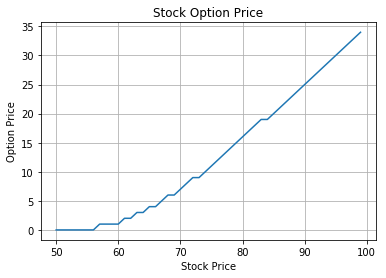

In [43]:
stockPrices = np.arange(50, 100, 1)
prices = stockPrices * 0

stockPrice = 60
strike = 65
timeToExpiration = 0.25
impliedVolatility = 0.30
riskFreeRate = 0.05
pl.title('Stock Option Price')

for i in range(len(stockPrices)):
    prices[i] = BlackScholes('c', stockPrices[i], strike, t = timeToExpiration, r = riskFreeRate, v = impliedVolatility)[0]

pl.plot(stockPrices, prices, label = 'Option Price')
pl.xlabel("Stock Price")
pl.ylabel("Option Price")
pl.grid(True)
pl.show()

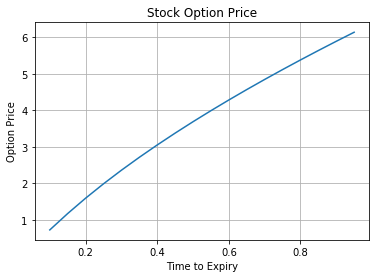

In [44]:
timeToExpiration = np.arange(0.1, 1, 0.05)
prices = timeToExpiration * 0

stockPrice = 60
strike = 65
#timeToExpiration = 0.25
impliedVolatility = 0.30
riskFreeRate = 0.05
pl.title('Stock Option Price')

for i in range(len(prices)):
    prices[i] = BlackScholes('c', stockPrice, strike, t = timeToExpiration[i], r = riskFreeRate, v = impliedVolatility)[0]

pl.plot(timeToExpiration, prices, label = 'Option Price')
pl.xlabel("Time to Expiry")
pl.ylabel("Option Price")
pl.grid(True)
pl.show()

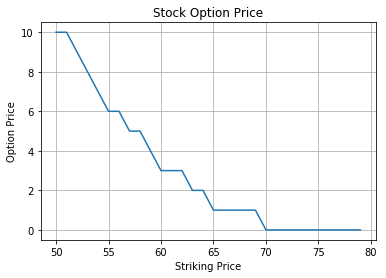

In [45]:
strikes = np.arange(50, 80, 1)
prices = strikes * 0

stockPrice = 60
strike = 65
timeToExpiration = 0.25
impliedVolatility = 0.30
riskFreeRate = 0.05
pl.title('Stock Option Price')

for i in range(len(prices)):
    prices[i] = BlackScholes('c', stockPrice, strikes[i], t = timeToExpiration, r = riskFreeRate, v = impliedVolatility)[0]

pl.plot(strikes, prices, label = 'Option Price')
pl.xlabel("Striking Price")
pl.ylabel("Option Price")
pl.grid(True)
pl.show()

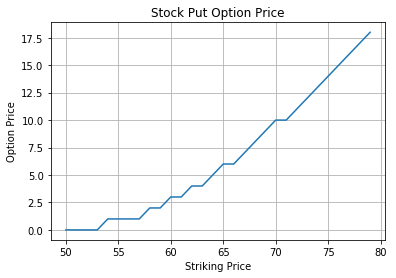

In [46]:
strikes = np.arange(50, 80, 1)
prices = strikes * 0

stockPrice = 60
strike = 65
timeToExpiration = 0.25
impliedVolatility = 0.30
riskFreeRate = 0.05
pl.title('Stock Put Option Price')

for i in range(len(prices)):
    prices[i] = BlackScholes('p', stockPrice, strikes[i], t = timeToExpiration, r = riskFreeRate, v = impliedVolatility)[0]

pl.plot(strikes, prices, label = 'Option Price')
pl.xlabel("Striking Price")
pl.ylabel("Option Price")
pl.grid(True)
pl.show()